# Introduction

In this vignette, we touch on the topic of cheminformatics and bioinformatics, aiming to predict the solubility of molecules using deep learning. The neural network we will be working on is called **Graph Neural Network**. It serves as a powerful tool for learning from graph-structured data, which is perfectly suitable for the molecular data which atoms and bonds can be represented as a graph.

The vignette is divided into three sections. In the first section, we will introduce the graph data structure. The second part will be about the data. In the last section, we will build a graph neural network to predict the solubility of molecules.

## Graph Data Structure

> A graph data structure consists of a finite (and possibly mutable) set of vertices (also called nodes or points), together with a set of unordered pairs of these vertices for an undirected graph or a set of ordered pairs for a directed graph. [1](https://en.wikipedia.org/wiki/Graph_(abstract_data_type))

### Implement a Graph Data Structure

![slide_1](./img/slides/slide_01.jpg)

Here is a short demo to implement an undirected graph data structure in Python using adjacency list.

```python
class vertex:
    def __init__(self, value):
        self.value = value # info the vertex stores
        self.index = None # index of the vertex in the graph
        self.edges = [] # list of edges connected to the vertex

class graph:
    def __init__(self):
        self.vertices = [] # list of vertices in the graph
        self.adjacency_list = {} # dictionary to store the vertices and edges
    
    def add_vertex(self, value):
        v = vertex(value)
        v.index = len(self.vertices) # assign index to the vertex
        self.vertices.append(v)
        self.adjacency_list[v.index] = [] # record the edges connected to the vertex
        return v
    
    def add_edge(self, v1, v2):
        self.adjacency_list[v1.index].append(v2.index) # v1 connects to v2
        self.adjacency_list[v2.index].append(v1.index) # v2 connects to v1
        v1.edges.append(v2)
        v2.edges.append(v1)

```

Usage:
    
```python
g = graph()
v1 = g.add_vertex(1)
v2 = g.add_vertex(2)
v3 = g.add_vertex(3)
g.add_edge(v1, v2)
g.add_edge(v2, v3)
```


### Your Task:
Implement a **directed** graph data structure in Python using adjacency matrix.

### What type of data can be represented as a graph?

Graph data structure can be used to represent most of data, like images and texts. One of the key features of graph data structure is that it can represent the relationship between data points.

- Images: Each pixel can be a node, and each node connects to all its neighbors.

- Texts: Each word can be a node, and each node connects to the words that appear in the same sentence.

![slide_02](./img/slides/slide_02.jpg)

Besides of texts and images. Molecules can be naturally represented as a graph, with atoms as nodes and bonds as edges.

![slide_03](./img/slides/slide_03.jpg)

## Data



## Data preview and preparation

To predict the solubility of molecules, we will use the **ESOL dataset** that is built in the **torch_geometric** packages and `datasets` modules. The dataset contains 1,128 molecules and their solubility in water. We will use **RDKit** to process the molecules.

**RDKit** is an open-source toolkit for cheminformatics. It provides a wide range of functions for processing molecules, such as reading and writing molecules, calculating molecular descriptors, and generating molecular fingerprints. Specifically, the `MoleculeNet` class in `torch_geometric.datasets` module utilized `from_smiles` to convert the SMILES representation of molecules to graph data structure.

> SMILES is a specification in the form of a line notation for describing the structure of chemical species using short ASCII strings [2](https://en.wikipedia.org/wiki/Simplified_Molecular_Input_Line_Entry_System)

For example, acetylsalicylic acid (aspirin) can be represented as `CC(=O)Oc1ccccc1C(=O)O`, and epinephrine can be represented as `CNC[C@H](O)c1ccc(O)c(O)c1`. [3](https://www.researchgate.net/figure/Example-SMILES-notations-for-various-molecules_fig2_339349026)

![SMILES](./img/SMILES.jpg)

ESOL provides the SMILES representation of a molecule and uses `from_smiles` to return a `Data` instance, which contains the following essentiall attribute:

- `x`: Node feature matrix with shape `[num_nodes, 9]`, where the `num_nodes` is the number of atoms in the molecule and 9 is the number of features per atom. These features that are stored in nodes are `atomic_num`, `chirality`, `degree`, `formal_charge`, `hybridization`, `is_aromatic`, `is_in_ring`, `num_radical_electrons`, and `num_hs`.

- `y`: Target to predict, which is `solubility` here.

- `edge_att`: Edge feature matrix with shape `[num_edges, 3]`, where the `num_edges` is the number of bonds in the molecule and 3 is the number of features that are stored in each bond. These features are `bond_type`, `is_conjugated`, and `stereo`.

- `edge_index`: Graph connectivity in COO format with shape `[num_edges, 2]`, where the first element in the first row is the source node and the first element in the second row is the target node.

![slide_04](./img/slides/slide_04.jpg)

### Code Demo

In [2]:
# use rdkit to generate molecule features while importing dataset
import rdkit
from torch_geometric.datasets import MoleculeNet

# Load and connect the ESOL dataset
data = MoleculeNet(root='.', name="ESOL")
data

ESOL(1128)

In [3]:
# Investigating the dataset
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data[0].y.shape[0])
print("Dataset length: ", data.len())
print("Dataset sample: ", data[0])
print("Sample nodes: ", data[0].num_nodes)
print("Sample edges: ", data[0].num_edges)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  1
Dataset length:  1128
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample nodes:  32
Sample edges:  68


Each node represents an atom with descriptive features such as atomic number, hybridization state, and charge. The node feature matrix for a graph has a shape [num_nodes, num_features], where each row is a node's feature vector.

In [44]:
# Investigating the features
# Shape: [num_nodes, num_node_features = 9]
data[0].x

tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 2, 5, 0, 0, 2, 0, 0],
        [7, 0, 1, 5, 0, 0, 2, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
 

Edges represent bonds information between atoms, stored efficiently in sparse COO format.

In [68]:
# Shape: [num_edges, edge_features = 3]
data[0].edge_attr

tensor([[ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 3,  0,  0],
        [ 3,  0,  0],
        [ 1,  0,  0],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [ 1,  0,  0],
        [ 

 Each edge is a pair of connected nodes, and the edge matrix has a shape [2, num_edges]. This format is computationally efficient for large, sparse graphs. Edges allow GNNs to propagate information between connected nodes, capturing molecular relationships and structure.

In [5]:
# Investigating the edges in sparse COO format
# Shape: [2, num_edges]
# i.e. node 0 is connected to node 1
# i.e. node 1 is connected to node 0
# i.e. node 1 is connected to node 2
# etc.
# NOTE: more efficient representation than adjacency matrix
data[0].edge_index.t()

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 2, 30],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 4, 26],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 7, 24],
        [ 8,  7],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [ 9, 20],
        [10,  9],
        [10, 11],
        [11, 10],
        [11, 12],
        [11, 14],
        [12, 11],
        [12, 13],
        [13, 12],
        [14, 11],
        [14, 15],
        [14, 19],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [17, 18],
        [18, 17],
        [18, 19],
        [19, 14],
        [19, 18],
        [20,  9],
        [20, 21],
        [20, 22],
        [21, 20],
        [22, 20],
        [22, 23],
        [22, 24],
        [23, 22],
        [24,  7],
        [24, 22],
        [24, 25],
        [2

Each sample in the dataset includes a target value y, the solubility of the corresponding molecule.

In [7]:
data[0].y

tensor([[-0.7700]])

### The SMILES Feature from ESOL

The ESOL dataset includes molecules in the form of SMILES (Simplified Molecular Input Line Entry System) strings, a standard representation for chemical structures. Using RDKit, these SMILES strings are converted into molecular graph representations for visualization and further processing.

In [47]:
data[0]["smiles"]

'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '

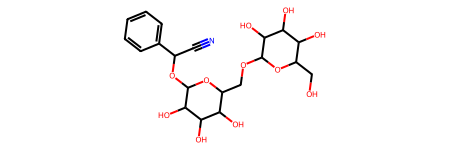

In [48]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

## Graph Neural Network

### What type of problem can be solved by Graph Neural Network?

Graph neural network utilizes the advantange of graph data structure to learn from graph-structured data, specially the connectivity and how information can be stored in all three components of graph, namely graph, nodes and edges. It is a powerful tool for learning from molecular data.

Typically, there are three types of problems that can be solved by graph neural network:

- Graph-level prediction: Predict the properties of the whole graph, such as the solubility of an entire molecule.

- Node-level prediction: Predict the properties of each node in the graph, such as the atom property of each atom in a molecule. For example, will the atom be in a ring? Will the atom be aromatic? Will the atom's hybridization be sp3? etc.

- Edge-level prediction: Predict the properties of each edge in the graph, such as the bond type of each bond in a molecule. For example, will the bond between the carbon and oxygen be a single bond or double bond? Will the bond be conjugated? Will the bond be stereo? etc.


Left: Graph-level prediction. Right: Node-level prediction.
![gnn_node_graph_prediction](./img//gnn_node_graph_prediction.jpg)

Clearly, our task is a **graph-level prediction problem**. We will build a graph neural network to predict the solubility of molecules.

### Graph Convolutional Network (GCN) Implementation

To deeply understand what everything is happening in the code, we will take a look at the source code of the Graph Convolutional Network (GCN) in PyTorch [pytorch_details.ipynb](). Along the way, we will only explain the mathematical and implementation details of the architecture in a high-level way.


#### Graph Convolutional Network (GCN) 

The key equation in the forward propagation of a GCN layer can essentially be summarized as follows:

$$\mathbf{X}' = \hat{\mathbf{D}}^{-\frac{1}{2}} \hat{\mathbf{A}} \hat{\mathbf{D}}^{-\frac{1}{2}} \mathbf{X} \Theta,$$

where
- $\Theta$ is the weight matrix of the layer, with $\Theta \in \mathbb{R}^{I \times O}$ where $I$ is the number of input features and $O$ is the number of output features.

- $\mathbf{X} \in \mathbb{R}^{N \times I}$ is the input feature matrix, where $N$ is the number of nodes and $I$ is the number of input features.

- $\hat{\mathbf{A}} = \mathbf{A} + \mathbf{I}$ is the adjacency matrix of the graph with added self-connections.

- $\hat{\mathbf{D}}$ is the degree matrix of $\hat{\mathbf{A}}$ that is normalized. It is a diagonal matrix with $\hat{D}_{ii} = \sum_j \hat{A}_{ij}$. The reason we need to normalized $\mathbf{A}$ is to prevent nodes with higher degrees (many neighbors) contribute much more to their neighbors' feature aggregation thus dominate the aggregated features.

![slide_05](./img/slides/slide_05.jpg)

For the example above,
$$
\hat{\mathbf{D}}^{-\frac{1}{2}} \hat{\mathbf{A}} \hat{\mathbf{D}}^{-\frac{1}{2}} = \begin{bmatrix}
\frac{1}{\sqrt{3}} & 0 & 0 \\
0 & \frac{1}{\sqrt{3}} & 0 \\
0 & 0 & \frac{1}{\sqrt{3}}
\end{bmatrix}
\begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1
\end{bmatrix}
\begin{bmatrix}
\frac{1}{\sqrt{3}} & 0 & 0 \\
0 & \frac{1}{\sqrt{3}} & 0 \\
0 & 0 & \frac{1}{\sqrt{3}}
\end{bmatrix}.
$$

$$
= \begin{bmatrix}
\frac{1}{\sqrt{3}} & \frac{1}{\sqrt{3}} & \frac{1}{\sqrt{3}} \\
\frac{1}{\sqrt{3}} & \frac{1}{\sqrt{3}} & \frac{1}{\sqrt{3}} \\
\frac{1}{\sqrt{3}} & \frac{1}{\sqrt{3}} & \frac{1}{\sqrt{3}}
\end{bmatrix}
\begin{bmatrix}
\frac{1}{\sqrt{3}} & 0 & 0 \\
0 & \frac{1}{\sqrt{3}} & 0 \\
0 & 0 & \frac{1}{\sqrt{3}}
\end{bmatrix}
= \begin{bmatrix}
\frac{1}{3} & \frac{1}{3} & \frac{1}{3} \\
\frac{1}{3} & \frac{1}{3} & \frac{1}{3} \\
\frac{1}{3} & \frac{1}{3} & \frac{1}{3}
\end{bmatrix}.
$$


The normalization factor is computed based on the degree of the nodes. It then applies to each feature of the nodes and aggregate the features of the neighbors. If a node doesn't connect to a node, then it will multiple the feature of that node by 0. This way cleverly utilizes the connectivity of the graph to aggregate the features of the neighbors.

$$
\hat{\mathbf{D}}^{-\frac{1}{2}} \hat{\mathbf{A}} \hat{\mathbf{D}}^{-\frac{1}{2}} \mathbf{X} = \begin{bmatrix}
\frac{1}{3} & \frac{1}{3} & \frac{1}{3} \\
\frac{1}{3} & \frac{1}{3} & \frac{1}{3} \\
\frac{1}{3} & \frac{1}{3} & \frac{1}{3}
\end{bmatrix}
\begin{bmatrix}
1 & 2 \\
-3 & 2 \\
2 & 1
\end{bmatrix}.
$$

$$
=\begin{bmatrix}
\frac{1}{3} \cdot 1 + \frac{1}{3} \cdot -3 + \frac{1}{3} \cdot 2  & \frac{1}{3} \cdot 2 + \frac{1}{3} \cdot 2 + \frac{1}{3} \cdot 1 \\
\frac{1}{3} \cdot 1 + \frac{1}{3} \cdot -3 + \frac{1}{3} \cdot 2  & \frac{1}{3} \cdot 2 + \frac{1}{3} \cdot 2 + \frac{1}{3} \cdot 1 \\
\frac{1}{3} \cdot 1 + \frac{1}{3} \cdot -3 + \frac{1}{3} \cdot 2  & \frac{1}{3} \cdot 2 + \frac{1}{3} \cdot 2 + \frac{1}{3} \cdot 1 
\end{bmatrix}
$$

$$
=\begin{bmatrix}
0 & \frac{5}{3} \\
0 & \frac{5}{3} \\
0 & \frac{5}{3}
\end{bmatrix}
$$

It then mapped $\mathbb{X}$ to a higher dimension space by multiplying the weight matrix $\Theta$.


$$
\mathbf{X} \cdot \Theta = \begin{bmatrix}
0 \cdot w_{00} + \frac{5}{3} \cdot w_{10} & 0 \cdot w_{01} + \frac{5}{3} \cdot w_{11} & 0 \cdot w_{02} + \frac{5}{3} \cdot w_{12} & 0 \cdot w_{03} + \frac{5}{3} \cdot w_{13} & 0 \cdot w_{04} + \frac{5}{3} \cdot w_{14} & 0 \cdot w_{05} + \frac{5}{3} \cdot w_{15} \\
0 \cdot w_{00} + \frac{5}{3} \cdot w_{10} & 0 \cdot w_{01} + \frac{5}{3} \cdot w_{11} & 0 \cdot w_{02} + \frac{5}{3} \cdot w_{12} & 0 \cdot w_{03} + \frac{5}{3} \cdot w_{13} & 0 \cdot w_{04} + \frac{5}{3} \cdot w_{14} & 0 \cdot w_{05} + \frac{5}{3} \cdot w_{15} \\
0 \cdot w_{00} + \frac{5}{3} \cdot w_{10} & 0 \cdot w_{01} + \frac{5}{3} \cdot w_{11} & 0 \cdot w_{02} + \frac{5}{3} \cdot w_{12} & 0 \cdot w_{03} + \frac{5}{3} \cdot w_{13} & 0 \cdot w_{04} + \frac{5}{3} \cdot w_{14} & 0 \cdot w_{05} + \frac{5}{3} \cdot w_{15} \\
\end{bmatrix}
$$

Here we chose the embedding size to be 6 for demonstration. In our model, we will use 64 as the embedding size, which is the number of columns in the weight matrix $\Theta$.



A global pooling layer combines max and mean pooling to aggregate node features into a graph-level representation, which is passed through a linear layer to predict the solubility value.

In [49]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

class GCN(torch.nn.Module):
  def __init__(self):
    # Init parent
    super(GCN, self).__init__()
    torch.manual_seed(197)

    # GCN layers
    self.initial_conv = GCNConv(data.num_features, embedding_size)
    self.conv1 = GCNConv(embedding_size, embedding_size)
    self.conv2 = GCNConv(embedding_size, embedding_size)
    self.conv3 = GCNConv(embedding_size, embedding_size)

    # Output layer
    self.out = Linear(embedding_size*2, data.y.shape[1]) # output shape 1 = regression
    # twice the size for accomodating the global pooling layer

  def forward(self, x, edge_index, batch_index):
    # First Conv layer
    hidden = self.initial_conv(x, edge_index)
    hidden = F.tanh(hidden) # activation function

    # Other Conv layers
    hidden = self.conv1(hidden, edge_index)
    hidden = F.tanh(hidden)
    hidden = self.conv2(hidden, edge_index)
    hidden = F.tanh(hidden)
    hidden = self.conv3(hidden, edge_index)
    hidden = F.tanh(hidden)

    # Global Pooling Layer (stack different aggregations)
    hidden = torch.cat([gmp(hidden, batch_index), 
                        gap(hidden, batch_index)], dim=1)
    # gmp = global max pooling
    # gap = gloabl average pooling
    # batch_index is used to select the relavent nodes for the pooling operation

    # Apply a final (linear) classifier.
    out = self.out(hidden)

    return out, hidden

### Graph Pooling

Aggregate all information of the final graph

![graph_pooling](./img/gnn_global_pooling.jpg)

## Model Summary and Parameter Count

The GCN model comprises an initial convolutional layer, three additional GCN layers, and a linear output layer, resulting in 107,806 parameters. This design balances complexity and computational efficiency, ensuring the model is expressive enough to capture molecular graph features while remaining practical for training.

In [50]:
print(data.y.shape[1])

1


In [51]:
model = GCN()
print(model)
print("Model parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Model parameters:  13249


## Training the GNN

### Batching with Graphs

Concatenate all node features in a large matrix. Combine each individual adjacency information into a large adjacency matrix or list.

NOTE: each individual graph is disconnected in the adjacency matrix, thus no information is shared between graphs.

![graph_batching](./img/gnn_batching.jpg)

The GNN is trained using the root MSE as the loss function and the Adam optimizer with a learning rate of 0.0007. The model is moved to a GPU if available, and the dataset is split 80:20 into training and testing sets. A DataLoader batches 64 graphs at a time, shuffling the data to ensure effective training.

In [52]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)],
                    batch_size=NUM_GRAPHS_PER_BATCH,
                    shuffle=True) # 20% training

test_loader = DataLoader(data[int(data_size * 0.8):],
                         batch_size=NUM_GRAPHS_PER_BATCH,
                         shuffle=True) # 80% testing

The GNN is trained over 2,000 epochs using batches of graphs. For each batch, predictions are made, loss is computed using root mean squared error, and gradients are updated to minimize the loss. The training progress is logged every 100 epochs, showing the model's improvement in solubility prediction.

In [53]:
def train(data):
  # Enumerate over the data
  for batch in loader:
    # Use GPU
    batch.to(device)
    # Reset gradients
    optimizer.zero_grad()
    # Passing the node features and the connection info
    pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
    # Calculating the loss and gradients
    loss = torch.sqrt(loss_fn(pred, batch.y))
    loss.backward()
    # Update using the gradients
    optimizer.step()
  return loss, embedding

print("Start training...")
losses = []
for epoch in range(2000):
  loss, h = train(data)
  losses.append(loss)
  if epoch % 100 == 0:
    print(f"Epoch {epoch} | Train Loss {loss}")

Start training...


Epoch 0 | Train Loss 2.18645977973938
Epoch 100 | Train Loss 0.7082846164703369
Epoch 200 | Train Loss 0.7985488772392273
Epoch 300 | Train Loss 0.5039166808128357
Epoch 400 | Train Loss 1.046067237854004
Epoch 500 | Train Loss 0.26778772473335266
Epoch 600 | Train Loss 0.6440434455871582
Epoch 700 | Train Loss 0.4965696334838867
Epoch 800 | Train Loss 0.4896949231624603
Epoch 900 | Train Loss 0.3031683564186096
Epoch 1000 | Train Loss 0.5666918754577637
Epoch 1100 | Train Loss 0.5001586079597473
Epoch 1200 | Train Loss 0.20951056480407715
Epoch 1300 | Train Loss 0.19144876301288605
Epoch 1400 | Train Loss 0.19382454454898834
Epoch 1500 | Train Loss 0.20428800582885742
Epoch 1600 | Train Loss 0.2662540078163147
Epoch 1700 | Train Loss 0.18329177796840668
Epoch 1800 | Train Loss 0.153456449508667
Epoch 1900 | Train Loss 0.12538152933120728


## Visualizing the Training Loss

<Axes: >

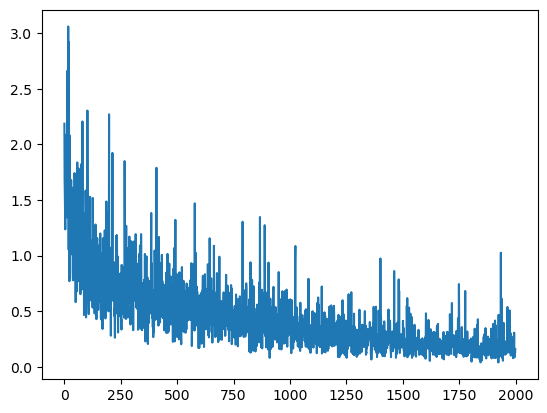

In [54]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i, l in enumerate(losses_float)]
plt = sns.lineplot(x=loss_indices, y=losses_float)
plt

## Getting a test prediction

The model is tested on a batch of data in inference mode, and the real (y_real) and predicted (y_pred) solubility values are extracted and stored in a DataFrame for easy analysis. A scatter plot shows their alignment, with points near the diagonal indicating strong prediction accuracy.

In [55]:
import pandas as pd

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
  test_batch.to(device)
  pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
  df = pd.DataFrame()
  df["y_real"] = test_batch.y.tolist()
  df["y_pred"] = pred.tolist()

df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,-3.790,-3.201251
1,-4.880,-2.633608
2,-2.218,-3.296799
3,-4.900,-4.461855
4,-0.900,0.959851
...,...,...
59,-3.360,-3.739055
60,-2.220,-3.236182
61,-2.943,-1.826369
62,-3.350,-5.849453


<Axes: xlabel='y_real', ylabel='y_pred'>

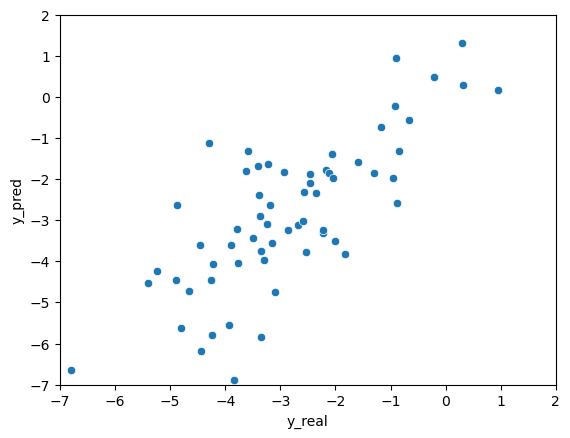

In [56]:
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt

## Improving the model:
- Dropouts
- Other (more intelligent) Pooling Layers
- Global Pooling Layers
- Batch Normalization
- More MP layers
- Other hidden state sizes
- Test metrics (test error) and Hyperparameter optimization
- ...